# 2023 전력 사용량 예측 AI 경진대회

- 대회 안내
    - 배경: 안정적이고 효율적인 에너지 공급을 위해서는 전력 사용량에 대한 정확한 예측 필요
           따라서, 한국에너지공단에서는 전력 사용량 예측 시뮬레이션을 통한 효율적인 인공지능 알고리즘 발굴이 목표
    - 주제: 전력 사용량 예측 AI 모델 개발
    - 설명: 건물 정보와 시공간 정보를 활용하여 특정 시점의 전력 사용량을 예측하는 AI 모델 개발

- Data Info.
    - train.csv
        - train 데이터: 100개이 건물들의 2022/06/01 ~ 2022/08/24 까지의 데이터
        - 일시별 기온, 강수량, 풍속, 습도, 일조, 일사 정보 포함
        - 전력 사용량(kWh)포함
    - building _info.csv
        - 100개 건물 정보
        - 건물 번호, 건물 유형, 연면적, 냉방 면적, 태양광 용량, ESS 저장 용량, PCS 용량
            - ESS(Energy Storage System): 에너지 저장 시스템은 전력을 저장하고 나중에 필요할 때 이를 공급하거나 소비하는 시스템
                - 주로 전력 그리드 안정화, 재생 에너지 효율 향상, 비상 대응 등의 목적으로 사용된다.
                - ESS는 에너지를 축적하여 사용자의 요구에 따라 전력의 공급과 소비를 조절할 수 있으며, 이로써 전력 시스템의 안정성과 효율성을 향상시킬 수 있다.
                - ESS 기술: 배터리, 슈퍼커패시터, 소스 연료전지
            - PCS(Power Conersion System): 전력 변환 시스템은 다양한 에너지 소스와 부하 사이의 에너지 변환과 전송을 담당하는 장치
                - 에너지 소스로부터 생성된 전력을 용도에 맞게 변환하여 전력 그리드에 공급하거나, 전력 그리드에서 가져온 전력을 부하로 전달하는 연할을 수행
                - PCS의 전력의 품질 유지, 효율적인 에너지 변환, 스마트 그리드 구축 등에 중요한 역할을 함
                - PCS의 구성요소: 인버터, 컨버터, 제어 시스템 등
    - test.csv
        - test 데이터: 100개의 건물들의 2020/08/25 ~ 2022/08/31 까지의 데이터
        - 일시별 기온, 강수량, 풍속, 습도의 예보 정보

- 필요한 지식
    - 계절 및 기상정보: 계절적 변동이나 기상 조건이 전력 사용량에 어떤 영향을 미치는 분석
    - 건물 정보: 건물의 특성이나 장비에 따라 전력 사용량 차이

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 데이터 확인하기

- building_info 데이터 확인하기

In [3]:
building_info = pd.read_csv('/Users/project/imputation_of_missing_values/building_info.csv')
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [4]:
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [5]:
building_info.describe()

,건물번호,연면적(m2),냉방면적(m2)
count,100.000000,1.000000e+02,1.000000e+02
mean,50.500000,2.608875e+05,1.864032e+05
std,29.011492,1.279963e+06,1.090638e+06
min,1.000000,5.578400e+03,0.000000e+00
25%,25.750000,6.144612e+04,2.318700e+04
50%,50.500000,9.264050e+04,5.582336e+04
75%,75.250000,1.848135e+05,9.915097e+04
max,100.000000,1.287288e+07,1.094194e+07


In [6]:
building_info['건물유형'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

<Axes: xlabel='연면적(m2)', ylabel='냉방면적(m2)'>

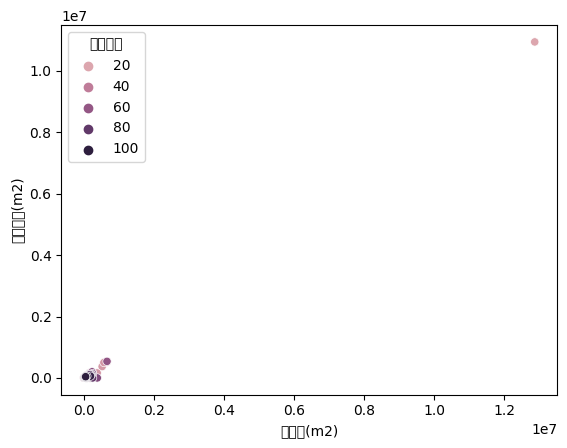

In [7]:
sns.scatterplot(x=building_info['연면적(m2)'], y=building_info['냉방면적(m2)'], hue=building_info['건물번호'])

- train data 데이터 확인하기

In [8]:
train_df = pd.read_csv('/Users/project/imputation_of_missing_values/train.csv')
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [10]:
train_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
count,204000.000000,204000.000000,43931.000000,203981.000000,203991.000000,128818.000000,116087.000000,204000.000000
mean,50.500000,25.543524,2.040830,2.134031,78.716295,0.333637,1.063823,2451.036462
std,28.866141,3.779523,5.165218,1.358109,15.080108,0.401486,1.001030,2440.648858
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000
50%,50.500000,25.700000,0.100000,2.000000,81.000000,0.100000,0.710000,1766.400000
75%,75.250000,28.100000,1.300000,2.800000,91.000000,0.700000,1.780000,2970.000000
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000


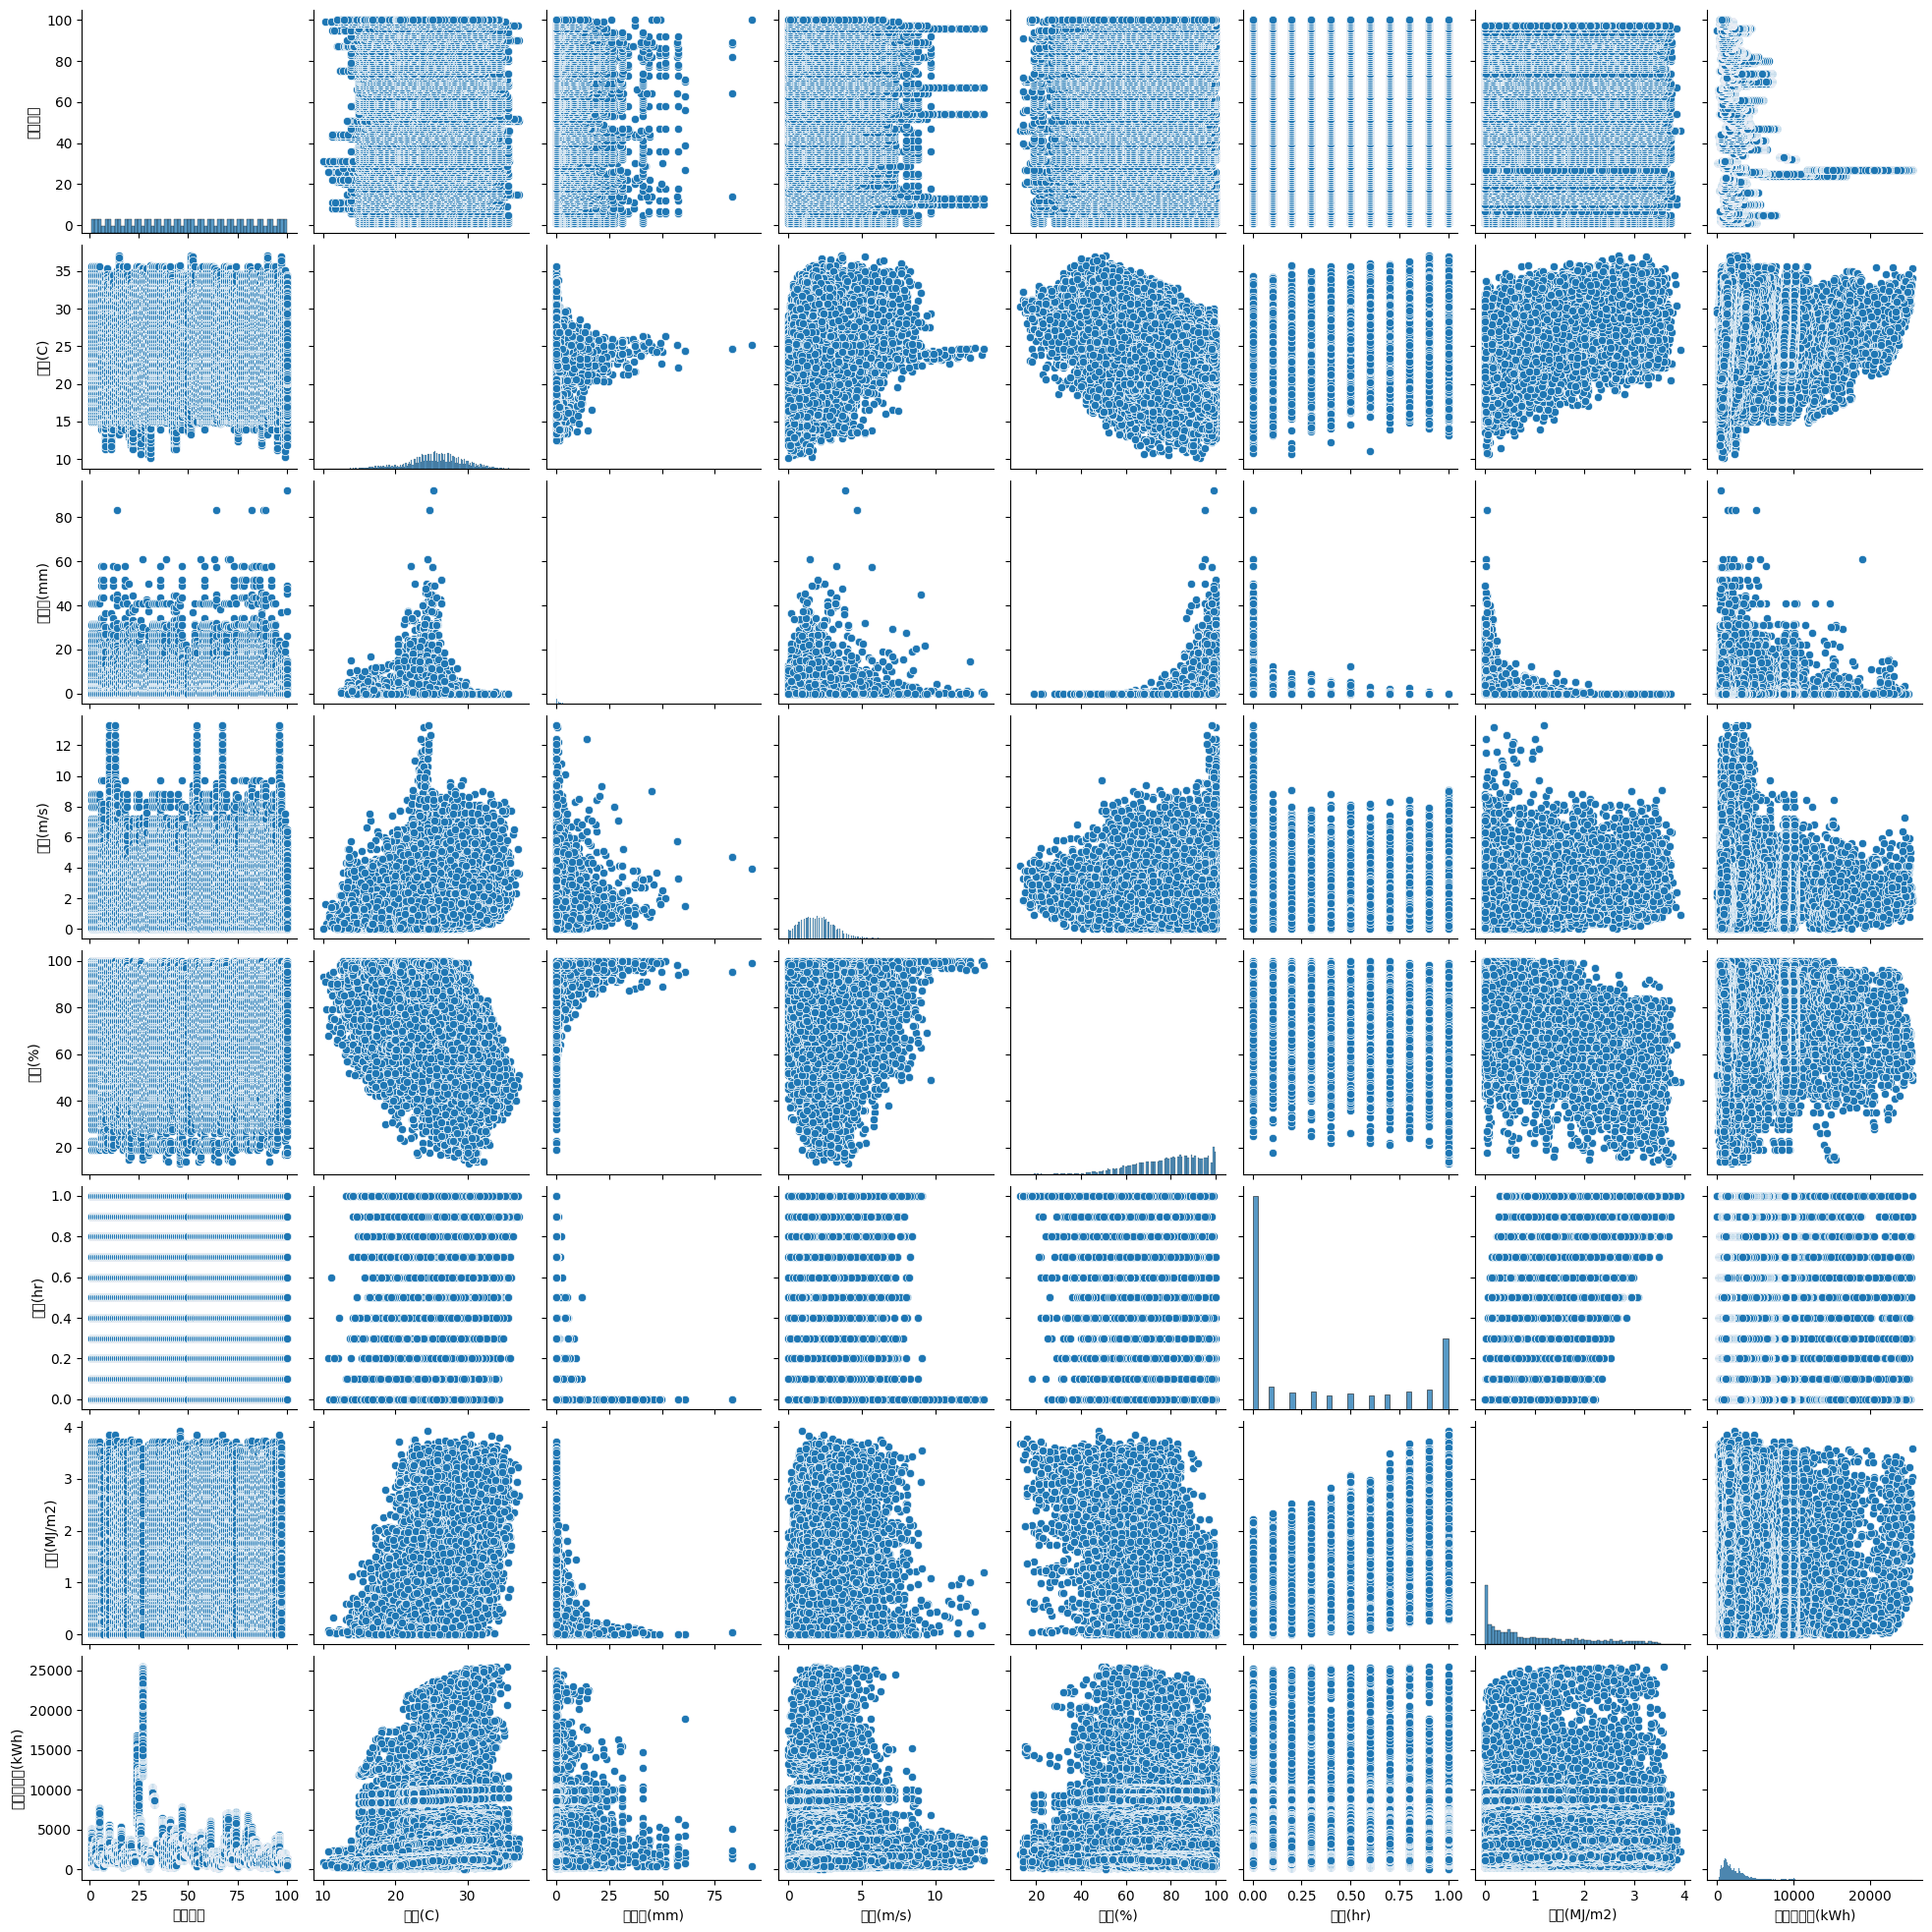

In [11]:
sns.pairplot(train_df)

- test data 데이터 확인하기

In [12]:
test_df = pd.read_csv('/Users/project/imputation_of_missing_values/test.csv')
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [14]:
test_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%)
count,16800.000000,16800.000000,16800.000000,16800.000000,16800.000000
mean,50.500000,21.975232,0.266720,1.783405,77.148036
std,28.866929,2.884010,1.130288,1.041896,16.080725
min,1.000000,12.200000,0.000000,0.000000,26.000000
25%,25.750000,19.900000,0.000000,1.000000,66.750000
50%,50.500000,21.700000,0.000000,1.700000,79.000000
75%,75.250000,23.600000,0.000000,2.500000,90.000000
max,100.000000,32.300000,18.800000,7.000000,100.000000


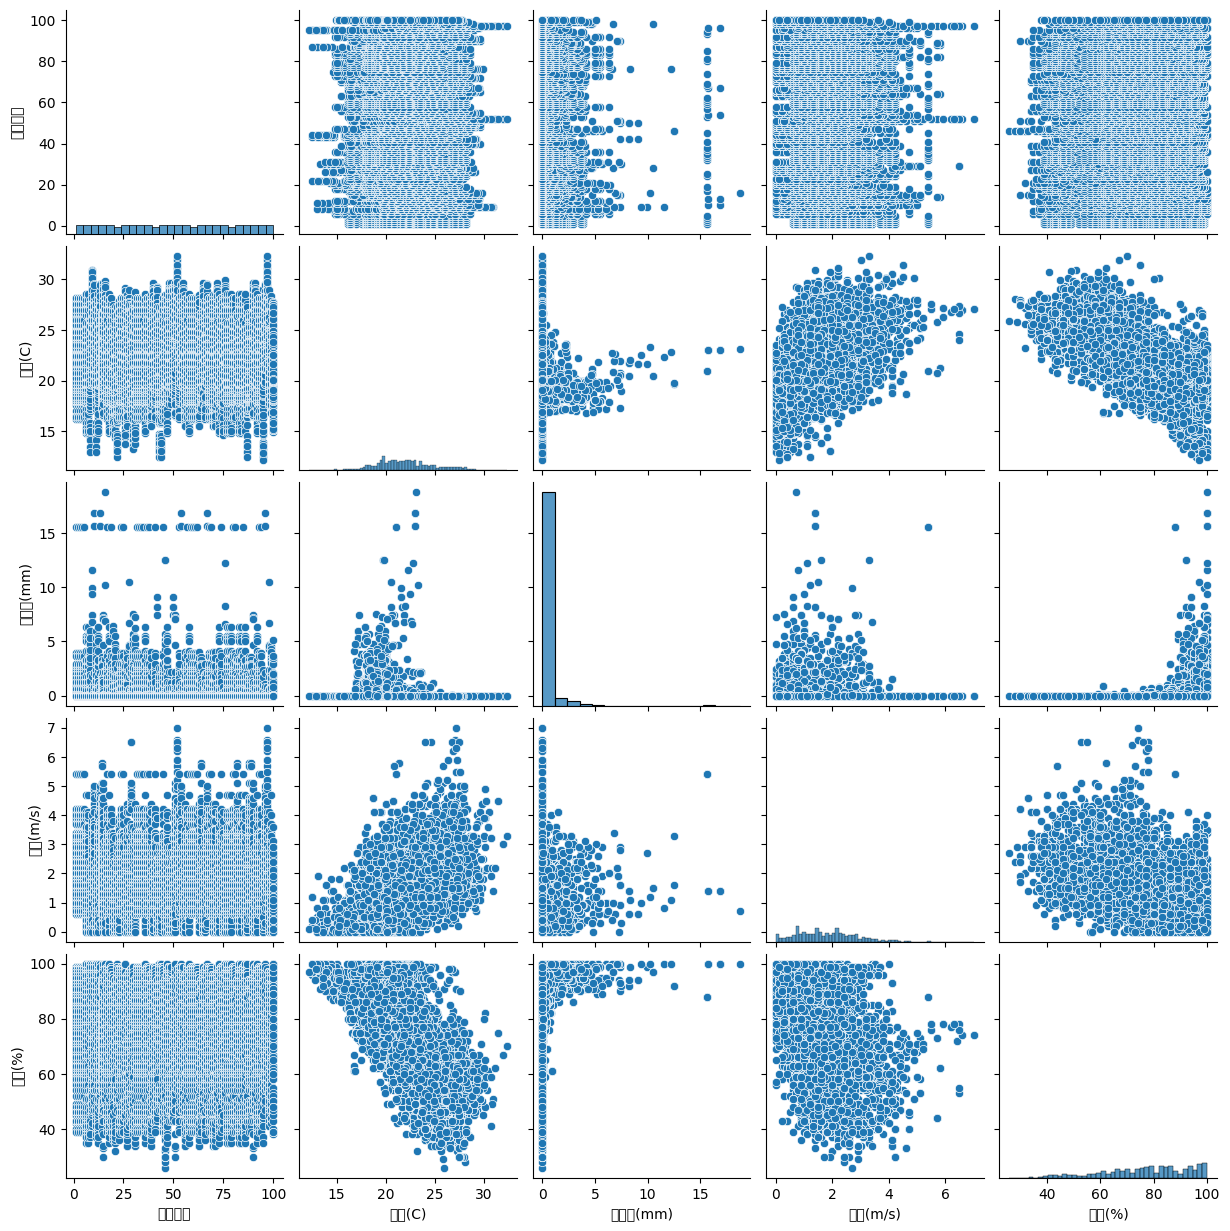

In [15]:
sns.pairplot(test_df)

### 데이터 변환

- train date 변환
- train/test data
    - num_date_time
        - num: 건물번호
        - date: 일시 (ex.20220601 ~ 20220824)
            - 0601 ~ 0824로 나누면 요일도 알 수 있음
            - 요일: 0 ~ 6(월 ~ 일)
        - time: 시간 (ex.0 ~ 23)
<br/><br/>
- 데이터 분할?변환?
    1. num_date_time drop
    2. date - 년, 월, 일, 시 (년도는 의미 없을 거 같아서 drop)
    3. 월, 일이 나오면 요일 구할 수 있음

In [16]:
train_df.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [17]:
def preprocess_csv(df, columns_order, datetime_column, datetime_format):
    # num_date_time drop
    df.drop(columns='num_date_time', inplace=True)

    # 일시 datetime으로 변환
    df[datetime_column] = pd.to_datetime(df[datetime_column], format=datetime_format)

    # 연도, 월, 일, 시간으로 분리
    df['연도'] = df[datetime_column].dt.year
    df['월'] = df[datetime_column].dt.month
    df['일'] = df[datetime_column].dt.day
    df['시간'] = df[datetime_column].dt.hour
    df['요일'] = df[datetime_column].dt.weekday

    df.drop(columns=datetime_column, inplace=True)

    df = df[columns_order]

    return df

In [18]:
datetime_column = ['건물번호', '연도', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']

train_df = preprocess_csv(train_df, datetime_column, '일시', '%Y%m%d %H')
train_df.head()

,건물번호,연도,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1,2022,6,1,2,0,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,2022,6,1,2,1,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1,2022,6,1,2,2,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1,2022,6,1,2,3,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1,2022,6,1,2,4,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [19]:
# 연도 drop 
train_df.drop(columns='연도', inplace=True)

/var/folders/zw/1zmd_ykn3zbd2m00vrvhv5m40000gn/T/ipykernel_4160/1388227071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns='연도', inplace=True)


In [20]:
train_df.columns

Index(['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   건물번호        204000 non-null  int64  
 1   월           204000 non-null  int32  
 2   일           204000 non-null  int32  
 3   요일          204000 non-null  int32  
 4   시간          204000 non-null  int32  
 5   기온(C)       204000 non-null  float64
 6   강수량(mm)     43931 non-null   float64
 7   풍속(m/s)     203981 non-null  float64
 8   습도(%)       203991 non-null  float64
 9   일조(hr)      128818 non-null  float64
 10  일사(MJ/m2)   116087 non-null  float64
 11  전력소비량(kWh)  204000 non-null  float64
dtypes: float64(7), int32(4), int64(1)
memory usage: 15.6 MB


In [22]:
train_df.corr()

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
건물번호,1.000000e+00,-2.790756e-14,3.608018e-15,-1.518670e-14,-3.480358e-15,-0.004505,-0.000248,0.021483,0.022985,0.024927,0.009761,-0.180474
월,-2.790756e-14,1.000000e+00,-1.333186e-01,-3.773670e-02,-8.672975e-17,0.427200,0.052792,-0.086350,0.253925,-0.068532,-0.059445,0.055842
일,3.608018e-15,-1.333186e-01,1.000000e+00,2.227065e-02,2.210557e-17,0.069498,0.017246,0.100220,0.118417,-0.107235,-0.093173,0.009233
요일,-1.518670e-14,-3.773670e-02,2.227065e-02,1.000000e+00,-1.304605e-18,0.042881,-0.036235,-0.106587,-0.013388,0.055141,0.029850,-0.043600
시간,-3.480358e-15,-8.672975e-17,2.210557e-17,-1.304605e-18,1.000000e+00,0.291429,0.038944,0.177099,-0.280593,0.078301,0.037752,0.099594
기온(C),-4.504794e-03,4.271998e-01,6.949836e-02,4.288145e-02,2.914288e-01,1.000000,-0.066500,0.220203,-0.389854,0.387001,0.476193,0.171190
강수량(mm),-2.477836e-04,5.279209e-02,1.724555e-02,-3.623513e-02,3.894437e-02,-0.066500,1.000000,0.028729,0.271468,-0.098351,-0.194009,0.015386
풍속(m/s),2.148265e-02,-8.635023e-02,1.002202e-01,-1.065870e-01,1.770987e-01,0.220203,0.028729,1.000000,-0.219095,0.093043,0.136162,0.109954
습도(%),2.298470e-02,2.539245e-01,1.184170e-01,-1.338796e-02,-2.805927e-01,-0.389854,0.271468,-0.219095,1.000000,-0.574123,-0.600839,-0.129546
일조(hr),2.492671e-02,-6.853208e-02,-1.072348e-01,5.514113e-02,7.830114e-02,0.387001,-0.098351,0.093043,-0.574123,1.000000,0.781689,0.021098


In [23]:
train_df.corr()['전력소비량(kWh)'].sort_values(ascending=False)

전력소비량(kWh)    1.000000
기온(C)         0.171190
풍속(m/s)       0.109954
시간            0.099594
일사(MJ/m2)     0.080357
월             0.055842
일조(hr)        0.021098
강수량(mm)       0.015386
일             0.009233
요일           -0.043600
습도(%)        -0.129546
건물번호         -0.180474
Name: 전력소비량(kWh), dtype: float64

- test data 변환

In [24]:
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [26]:
datetime_column = ['건물번호', '연도', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']

test_df = preprocess_csv(test_df, datetime_column, '일시', '%Y%m%d %H')
test_df.head()

,건물번호,연도,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1,2022,8,25,3,0,23.5,0.0,2.2,72
1,1,2022,8,25,3,1,23.0,0.0,0.9,72
2,1,2022,8,25,3,2,22.7,0.0,1.5,75
3,1,2022,8,25,3,3,22.1,0.0,1.3,78
4,1,2022,8,25,3,4,21.8,0.0,1.0,77


In [27]:
test_df.drop(columns='연도', inplace=True)

/var/folders/zw/1zmd_ykn3zbd2m00vrvhv5m40000gn/T/ipykernel_4160/4156003041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns='연도', inplace=True)


In [28]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   건물번호     16800 non-null  int64  
 1   월        16800 non-null  int32  
 2   일        16800 non-null  int32  
 3   요일       16800 non-null  int32  
 4   시간       16800 non-null  int32  
 5   기온(C)    16800 non-null  float64
 6   강수량(mm)  16800 non-null  float64
 7   풍속(m/s)  16800 non-null  float64
 8   습도(%)    16800 non-null  int64  
dtypes: float64(3), int32(4), int64(2)
memory usage: 918.9 KB


In [29]:
test_df.corr()

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%)
건물번호,1.000000e+00,NaN,1.110187e-14,2.300184e-15,1.102625e-15,0.035453,-0.021608,0.016300,-0.010992
월,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
일,1.110187e-14,NaN,1.000000e+00,-5.000000e-01,-2.025448e-17,-0.278735,0.193009,-0.064808,0.354681
요일,2.300184e-15,NaN,-5.000000e-01,1.000000e+00,2.389754e-17,0.198585,-0.158795,0.064511,-0.484938
시간,1.102625e-15,NaN,-2.025448e-17,2.389754e-17,1.000000e+00,0.330249,-0.062059,0.143280,-0.239877
기온(C),3.545281e-02,NaN,-2.787352e-01,1.985854e-01,3.302485e-01,1.000000,-0.186591,0.302183,-0.636563
강수량(mm),-2.160844e-02,NaN,1.930086e-01,-1.587954e-01,-6.205893e-02,-0.186591,1.000000,0.110601,0.268557
풍속(m/s),1.630018e-02,NaN,-6.480769e-02,6.451060e-02,1.432801e-01,0.302183,0.110601,1.000000,-0.406199
습도(%),-1.099195e-02,NaN,3.546813e-01,-4.849376e-01,-2.398768e-01,-0.636563,0.268557,-0.406199,1.000000


## 결측치 확인하기

### train data 결측치 확인하기

- 결측치를 삭제 안하고 모두 예측 값으로 대체 함
- 실제 날씨 데이터를 가져와서 넣기?(외부 데이터 사용금지)

In [30]:
# 결측치 확인
train_df.isna().sum()

건물번호               0
월                  0
일                  0
요일                 0
시간                 0
기온(C)              0
강수량(mm)       160069
풍속(m/s)           19
습도(%)              9
일조(hr)         75182
일사(MJ/m2)      87913
전력소비량(kWh)         0
dtype: int64

-  결측치 데이터 그래프 그리기

<Axes: ylabel='Frequency'>

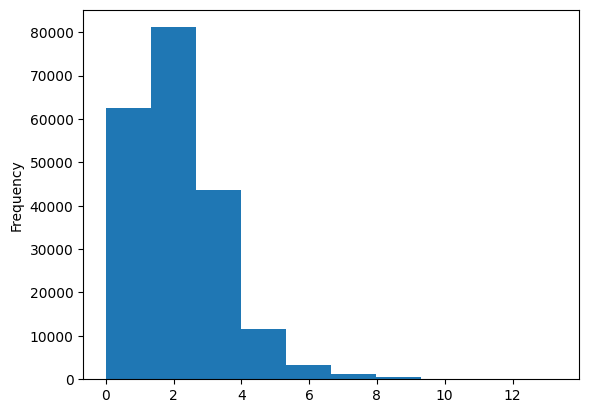

In [31]:
train_df['풍속(m/s)'].plot(kind='hist')

<Axes: ylabel='Frequency'>

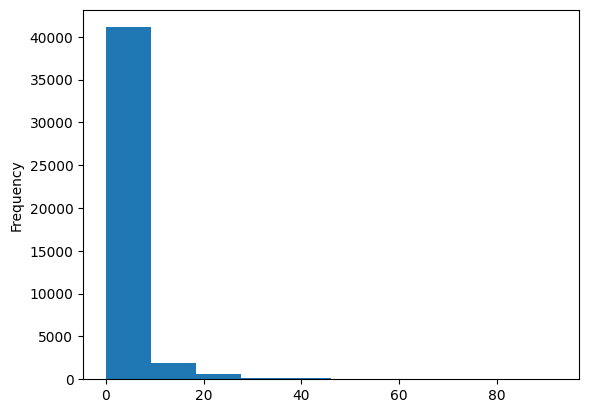

In [32]:
train_df['강수량(mm)'].plot(kind='hist')

<Axes: ylabel='Frequency'>

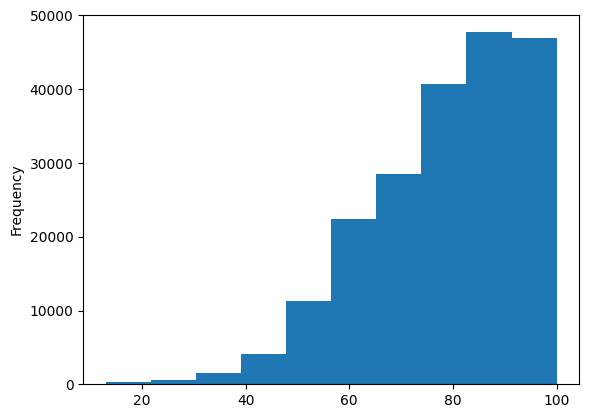

In [33]:
train_df['습도(%)'].plot(kind='hist')

<Axes: ylabel='Frequency'>

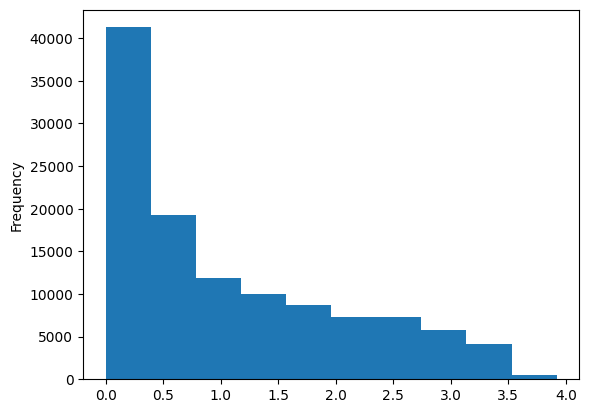

In [34]:
train_df['일사(MJ/m2)'].plot(kind='hist')

<Axes: ylabel='Frequency'>

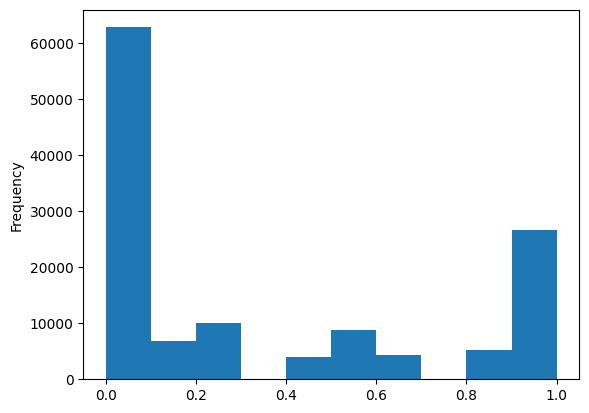

In [35]:
train_df['일조(hr)'].plot(kind='hist')

- 결측치를 처리하는 방법
    - 결측치 대체: 평균값, 중앙값, 최빈값 같은 데이터로 대체
    - 삭제: 결측치가 일부인 데이터 삭제(단, 데이터 양이 크게 줄 수 있음)
    - 예측 모델 활용: 다른 특성들을 활용하여 결측치를 예측하는 모델 사용
    - 다중 대체: 여러 결측치 대체 기법을 조합하여 결측치 대체

- 풍속, 습도는 비교적으로 결측치가 작기 때문에 미리 처리해준다. 

In [36]:
# 결측치 행만 출력
train_df[train_df.isna().any(axis=1)].shape

(177612, 12)

In [37]:
# 풍속, 습도는 상대적으로 결측치가 작기 때문에 미리 처리해준다.
print('풍속 평균: ', train_df['풍속(m/s)'].mean())
print('풍속 표준편차: ', train_df['풍속(m/s)'].std())
print('풍속 최빈값: ', train_df['풍속(m/s)'].value_counts().index[0])
print('-' * 30)
print('습도 평균: ',train_df['습도(%)'].mean())
print('습도 표준편차: ', train_df['습도(%)'].std())
print('습도 최빈값: ', train_df['습도(%)'].value_counts().index[0])

풍속 평균:  2.1340311107407057
풍속 표준편차:  1.3581086282672654
풍속 최빈값:  2.2
------------------------------
습도 평균:  78.71629483653692
습도 표준편차:  15.08010751320269
습도 최빈값:  99.0


- 평균으로 할까? 최빈값으로 할까
    - 기상청 데이터를 본 결과 6 ~ 8월까지의 풍속평균: 2.3, 습도 평균: 약 77%
    - 평균값으로 했을 때 장단점
        - 장점: 결측치 대체가 간단하며, 데이터셋에 미치는 영향을 상대적으로 적게 만들 수 있다.
        - 단점
            - 데이터의 실제 분포와 일치하지 않을 수 있다.
            - 결측치가 있는 특정 상황이나 패턴을 무시할 수 있다.
            - 이상치의 영향을 받을 수 있다.
            - 모델이 잘못된 패턴을 학습할 수 있다.
    - 최빈값으로 했을 때 장단점
        - 장점
            - 결측치를 대체하는 과정이 간단하고 빠르며 구현하기 쉽다.
            - 최빈값을 데이터의 분포를 유지하려는 시도로 볼 수 있다. <br/>
              결측치를 대체하는 과정에서 다른 값들을 고려하지 않고, 가장 많이 나타나는 값으로 데이터셋의 특징을 크게 바꾸지 않음
        - 단점
            - 최빈값으로 대체할 경우, 예측치와 실제값 사이의 오차가 커질 수 있다. <br/>
              특히 이상치나 특이값이 많은 경우에는 대체된 값이 원본 데이터와 다를 수 있다.
            - 최빈값은 데이터의 특성을 반영하지 않고 결측치를 대체하므로, 특정 특성이나 패턴을 무시할 수 있다.
            - 다른 변수와의 상관관계를 고려하지 않고 대체하기 때문에, 변수 간의 관계가 중요한 경우 이를 무시하게 된다.

In [38]:
train_df[train_df['풍속(m/s)'].isna()]

,건물번호,월,일,요일,시간,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
16643,9,6,14,1,11,17.6,NaN,NaN,NaN,NaN,NaN,2330.40
30161,15,8,6,5,17,35.6,NaN,NaN,NaN,NaN,NaN,1815.57
32127,16,8,3,2,15,30.4,NaN,NaN,77.0,0.5,2.06,5062.08
51640,26,6,27,0,16,27.2,3.1,NaN,93.0,0.0,0.27,5330.40
51921,26,7,9,5,9,26.3,NaN,NaN,84.0,0.0,0.81,2908.80
84418,42,7,3,6,10,29.8,NaN,NaN,66.0,1.0,2.61,3038.76
100738,50,7,3,6,10,29.8,NaN,NaN,66.0,1.0,2.61,3044.70
105639,52,8,6,5,15,33.4,NaN,NaN,72.0,0.0,NaN,2260.20
105640,52,8,6,5,16,33.5,NaN,NaN,73.0,0.0,NaN,2274.30
176477,87,7,14,3,5,21.9,NaN,NaN,NaN,NaN,NaN,519.66


- 예측 모델을 만드는 이유?
    - 결측치가 있는 특성을 다른 특성이나 시간에 따른 패턴을 분석하고 예측하여 결측치를 대체하는 방법
    - 즉, 결측치를 가진 데이터 포인트의 다른 특성을 활용하여 예측 모델을 학습시키고 이 모델을 활용하여 결측치를 예측하여 대체하는 것!
    - 이 방법은 결측치를 간접적으로 채워넣는 방법으로, 주로 회귀 분석이나 다른 예측 모델을 사용한다.

    - 주의 해야할 점
        - 결측치 예측 모델의 정확도와 일반화 능력을 평가하고, 도메인 지식을 활용하여 모델이 합리적인 예측을 하는지 확인하는 것이 중요하다.
        - 결측치 처리 방법을 결정할 때 데이터으 ㅣ특성과 모델의 성능을 고려하는 것이 좋다.

In [39]:
train_df.columns

Index(['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [62]:
from sklearn.ensemble import RandomForestRegressor

# 결측치를 대체할 열들과 예측할 열 선택
features_to_predict = ['강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
target_feature = '전력소비량(kWh)'

# 결측치가 없는 열 선택
train_features = ['건물번호', '월', '일', '요일', '시간', '기온(C)', target_feature]

# 결측치 있는 행과 없는 행으로 분할
data_without_nan = train_df.dropna(subset=features_to_predict)
data_with_nan = train_df[train_df[features_to_predict].isnull().any(axis=1)]

# train 데이터 준비
X_train_m = data_without_nan.drop(columns=features_to_predict)
y_train_m = data_without_nan[features_to_predict]

# 모델 생성 및 훈련
model = RandomForestRegressor()
model.fit(X_train_m, y_train_m)

# test 데이터 준비
X_test_m = data_with_nan.drop(columns=features_to_predict)

# 예측 수행
predict = model.predict(X_test_m)

# 예측값으로 결측치 대체
train_df.loc[data_with_nan.index, features_to_predict] = predict

# 결측치 대체 후 확인
train_df.isna().sum()


건물번호          0
월             0
일             0
요일            0
시간            0
기온(C)         0
강수량(mm)       0
풍속(m/s)       0
습도(%)         0
일조(hr)        0
일사(MJ/m2)     0
전력소비량(kWh)    0
dtype: int64

train_with_nan = train_df.dropna(subset=featuere_predict)
- train_df 데이터프레임에서 feature_predict 리스트에 있는 열들 중 하나라도 결측치가 있는 행들 제거
    - feature_predict 열 중 하나라도 결측치가 있는 행들은 train_without_nan 데이터 프레임에 포함되지 않음

train_with_nan = train_df[train_df[featuere_predict].isna().any(axis=1)] 
- train_df 데이터프레임에서 feature_predict 리스트에 있는 열들 중 하나라고 결측치가 있는 행들만 선택
- isna().any(axis=1): 각 행에 대해 feature_predict 열들 중 하나라도 결측치가 있는지 확인

보통 머신러닝 모델에서는 
- X는 입력 데이터의 특성(feature)을 나타내는 행렬이나 다차원 배열
- y는 예측하려는 타겟 변수(target)을 나타내는 벡터
- 하지만, 다양한 상황에 따라 X, y의 형태는 달라질 수 있다.

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

# 결측치가 있는 특성 선택
feature_to_impute = ['강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
target_feature = '전력소비량(kWh)'

# train 데이터 준비
X_train_impute = train_df.drop(columns=feature_to_impute)  # 결측치 처리에 사용할 특성을 제외한 나머지 특성
y_train_impute = train_df[feature_to_impute]                # 결측치를 예측하고자 하는 특성

# KNNImputer 모델 생성
imputer = KNNImputer(n_neighbors=5)  # 이웃의 개수를 설정합니다.

# KNNImputer를 사용하여 결측치 처리
X_train_imputed = imputer.fit_transform(X_train_impute)
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train_impute.columns)

# 원래 특성과 처리된 특성을 합쳐서 결측치 처리된 데이터프레임 생성
train_df_imputed = pd.concat([X_train_imputed_df, y_train_impute], axis=1)

# 모델 생성 및 훈련
model = RandomForestRegressor()
model.fit(train_df_imputed.drop(columns=feature_to_impute), train_df_imputed[target_feature])

# 결측치 처리
# test 데이터에 결측치가 있는 경우에만 예측
if not train_with_nan.empty:
    # test 데이터 준비
    X_test_impute = train_with_nan.drop(columns=feature_to_impute)

    # 예측 수행
    predict = model.predict(X_test_impute)

    # 예측값으로 결측치 대체
    train_df.loc[train_with_nan.index, feature_to_impute] = predict


In [59]:
train_df.isna().sum()

건물번호               0
월                  0
일                  0
요일                 0
시간                 0
기온(C)              0
강수량(mm)       160069
풍속(m/s)           19
습도(%)              9
일조(hr)         75182
일사(MJ/m2)      87913
전력소비량(kWh)         0
dtype: int64

In [ ]:
train_df['일사(MJ/m2)'].unique()

In [ ]:
train_df['강수량(mm)'].unique()

In [ ]:
train_df.corr()['전력소비량(kWh)'].sort_values(ascending=False)

### building info 결측치 확인하기

In [ ]:
print('태양광용량: ', building_info['태양광용량(kW)'].value_counts().iloc[0])            # 64
print('ESS저장용량: ', building_info['ESS저장용량(kWh)'].value_counts().iloc[0])        # 95
print('PCS용량: ', building_info['PCS용량(kW)'].value_counts().iloc[0])               # 95

In [ ]:
building_info.isna().sum()

In [ ]:
building_info.columns

## 모델링

- 데이터 분할

In [63]:
train_df.columns

Index(['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [64]:
test_df.columns

Index(['건물번호', '월', '일', '요일', '시간', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)'], dtype='object')

In [65]:
X_train = train_df.drop(['일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
y_train = train_df['전력소비량(kWh)']
X_test = test_df

### randomforest

In [66]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
rfr_model = RandomForestRegressor()

# 모델 학습
rfr_model.fit(X_train, y_train)

# 테스트 데이터 예측
rfr_pred = rfr_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", rfr_pred)

Predicted Power Consumption on Test Data: [2107.135681   2037.238704   1945.58177171 ...  730.943997    644.442435
  475.495233  ]


### LinearRegrssion

In [67]:
from sklearn.linear_model import LinearRegression

# 모델 생성
reg_model = LinearRegression()

# 모델 학습
reg_model.fit(X_train, y_train)

# 테스트 데이터 예측
reg_pred = reg_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", reg_pred)

Predicted Power Consumption on Test Data: [2953.70987419 2842.03661846 2843.55910012 ... 1199.30608154 1258.61951639
 1105.66861812]


### XGBoost

In [68]:
from xgboost import XGBRegressor

# XGBoost 모델 생성
xgb_model = XGBRegressor()

# 모델 훈련
xgb_model.fit(X_train, y_train)

# 예측 수행
y_test_pred_xgb = xgb_model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", y_test_pred_xgb)

Predicted Power Consumption on Test Data: [1951.2207  1945.0798  1778.9336  ...  826.29614  651.53296  488.33682]


### svm

In [ ]:
from sklearn.svm import SVR

# 모델 생성
svm_model = SVR(kernel='linear')

# 모델 학습
svm_model.fit(X_train, y_train)

# 모델 예측
svm_pred = model.predict(X_test)

# 결과 출력
print("Predicted Power Consumption on Test Data:", svm_pred)

### 신경망 회귀

In [71]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 신경망 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # 출력 레이어
])

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 적용
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=100, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# 예측 수행
y_test_pred = model.predict(X_test_scaled).flatten()

2023-08-13 20:29:19.452059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1632/1632 [==============================] - 5s 3ms/step - loss: 7309492.5000 - val_loss: 1252242.1250
Epoch 2/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6750294.5000 - val_loss: 1278135.7500
Epoch 3/100
1632/1632 [==============================] - 4s 3ms/step - loss: 6705767.5000 - val_loss: 986680.3125
Epoch 4/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6644849.0000 - val_loss: 1220923.2500
Epoch 5/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6620241.5000 - val_loss: 1005157.6875
Epoch 6/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6612038.5000 - val_loss: 977218.4375
Epoch 7/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6602685.5000 - val_loss: 986662.0625
Epoch 8/100
1632/1632 [==============================] - 4s 2ms/step - loss: 6590008.0000 - val_loss: 1120641.3750
Epoch 9/100
1632/1632 [==============================] - 4s 2ms/step - loss: 654812

### csv file 저장

In [72]:
last_df = pd.read_csv('/Users/project/imputation_of_missing_values/sample_submission.csv')

In [ ]:
def save_predictions_to_csv(predictions, filename, y_pred):
    predictions['answer'] = y_pred
    predictions.to_csv(filename, index=False)

# 예측값과 해당 시간 정보를 가지고 있는 DataFrame 생성
predictions_df = pd.DataFrame({
    'num_date_time': last_df['num_date_time'],  # 테스트 데이터의 시간 정보
})

# CSV 파일로 저장
save_predictions_to_csv(predictions_df, 'sample_submission.csv', y_test_pred_nn)
